In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import torchvision
import numpy as np
from torch.autograd import Variable
%matplotlib inline
num_epochs = 10
batch_size = 64
learning_rate = 0.001

In [2]:
def get_variable(x):
    x = Variable(x)
    return x.cuda() if torch.cuda.is_available() else x

In [3]:
map_location="cpu"

In [4]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.5,],std=[0.5,])])

In [10]:
transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Lambda(lambda x: x.repeat(3,1,1)),
     transforms.Normalize(mean=[0.5,], std=[0.5,])]) 

In [ ]:
data_train = datasets.MNIST(root = "./data/",
                            transform=transform,
                            train = True,
                            download = True)

data_test = datasets.MNIST(root="./data/",
                           transform = transform,
                           train = False)

In [6]:
data_loader_train = torch.utils.data.DataLoader(dataset=data_train,
                                                batch_size = 64,
                                                shuffle = True,
                                                 num_workers=2)

data_loader_test = torch.utils.data.DataLoader(dataset=data_test,
                                               batch_size = 64,
                                               shuffle = True,
                                                num_workers=2)

In [145]:
print(len(data_train))

60000


import math

def isPrime(n):
    for i in range(2, int(math.sqrt(n)) + 1):
        if n%i == 0:
            return False

    return True



#limits calculated using prime number theory by hand
primes=[]
for num in range(104319,114319):
    if isPrime(num):
        primes.append(num)

[tensor(9), tensor(6), tensor(5), tensor(7), tensor(1), tensor(5), tensor(3), tensor(4), tensor(8), tensor(6), tensor(8), tensor(6), tensor(1), tensor(4), tensor(4), tensor(2), tensor(6), tensor(2), tensor(5), tensor(1), tensor(7), tensor(0), tensor(0), tensor(9), tensor(5), tensor(9), tensor(0), tensor(6), tensor(9), tensor(7), tensor(2), tensor(3), tensor(9), tensor(8), tensor(3), tensor(6), tensor(5), tensor(8), tensor(2), tensor(4), tensor(8), tensor(2), tensor(0), tensor(7), tensor(6), tensor(0), tensor(3), tensor(4), tensor(8), tensor(3), tensor(7), tensor(8), tensor(1), tensor(2), tensor(5), tensor(6), tensor(8), tensor(3), tensor(6), tensor(3), tensor(1), tensor(0), tensor(5), tensor(9)]


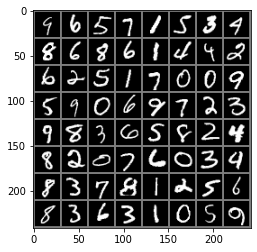

In [7]:
images,labels=next(iter(data_loader_train))
img=torchvision.utils.make_grid(images)
img=img.numpy().transpose(1,2,0)
std=[0.5,0.5,0.5]
mean=[0.5,0.5,0.5]
img=img*std+mean 
#if img.mode != 'L':
#  img = img.convert('L')
print([labels[i] for i in range(64)])
plt.imshow(img)
plt.show()

In [8]:
class Model(torch.nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1),
                                         torch.nn.ReLU(),
                                         torch.nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
                                         torch.nn.ReLU(),
                                         torch.nn.MaxPool2d(stride=2,kernel_size=2))
        self.dense = torch.nn.Sequential(torch.nn.Linear(14*14*128,1024),
                                         torch.nn.ReLU(),
                                         torch.nn.Dropout(p=0.5),
                                         torch.nn.Linear(1024, 10))
    def forward(self, x):
        x = self.conv1(x)
        #x = self.conv2(x)
        x = x.view(-1, 14*14*128)
        x = self.dense(x)
        return x

In [9]:
# 对模型进行训练和参数优化
model = Model()
#if torch.cuda.is_available():
#    model = model.cuda()
cost = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
n_epochs = 5
for epoch in range(n_epochs):
    running_loss = 0.0
    running_correct = 0
    print("Epoch {}/{}".format(epoch, n_epochs))
    print("-"*10)
    for data in data_loader_train:
        X_train, y_train = data
        X_train, y_train = Variable(X_train), Variable(y_train)
        outputs = model(X_train)
        _,pred = torch.max(outputs.data, 1)
        optimizer.zero_grad()
        loss = cost(outputs, y_train)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.data
        running_correct += torch.sum(pred == y_train.data)
    testing_correct = 0
    for data in data_loader_test:
        X_test, y_test = data
        X_test, y_test = Variable(X_test), Variable(y_test)
        outputs = model(X_test)
        _, pred = torch.max(outputs.data, 1)
        testing_correct += torch.sum(pred == y_test.data)
    print("Loss is:{:.4f}, Train Accuracy is:{:.4f}%, Test Accuracy is:{:.4f}".format(running_loss/len(data_train),
                                                                                      100*running_correct/len(data_train),
                                                                                      100*testing_correct/len(data_test)))
torch.save(model.state_dict(), "model_parameter.pkl")

Epoch 0/5
----------


KeyboardInterrupt: ignored

In [62]:
#print(model.state_dict().keys())                                # 输出模型参数名称
# torch.save(model.state_dict(), "/content/data/MNIST/model_parameter.pkl")
# model = Model()                                                    # 调用模型Model                                                 # 进行使用

In [134]:
# cost = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters())
# n_epochs = 5
# model.load_state_dict(torch.load('/content/data/MNIST/model_parameter.pkl'))

<All keys matched successfully>

In [10]:
%pwd

'/content'